# STM Transit Delay Data Modeling

This notebook explores three tree-based regression models in order to find the one that predicts the delay with the best accuracy.

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor

## Split the data

In [2]:
df = pd.read_csv('../data/preprocessed.csv')

In [3]:
# Separate the features from the target variable
X = df.drop('delay', axis=1)
y = df['delay']

In [4]:
# Train-validation-test split (70-15-15) 
# Use 70% for training because the dataset is large
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Since tree-based regression models are tested in this project, scaling is not needed because the models are not sensitive to the absolute scale or distribution of the features.

## Base Model: Random Forest Regression

### Fit Model

In [5]:
base_model = RandomForestRegressor(n_estimators=5, random_state=42)
base_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=5, random_state=42)

In [6]:
y_pred = base_model.predict(X_val)

### Evaluate Model

#### Metrics

In [7]:
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

In [8]:
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 62.99
MSE: 111624.32
RMSE: 334.10
R²: 0.3280


**MAE**<br>
On average, the predictions are off by 55 seconds, which seems reasonable.

**RMSE**<br>
The number being much larger than MAE suggests some big errors are present.

**R²**<br>
The model explains 46% of the variance in the actual delays, which is not too bad, considering how noisy and random transit delays can be (weather, mechanical issues, accidents, etc.)

#### Residual Analysis

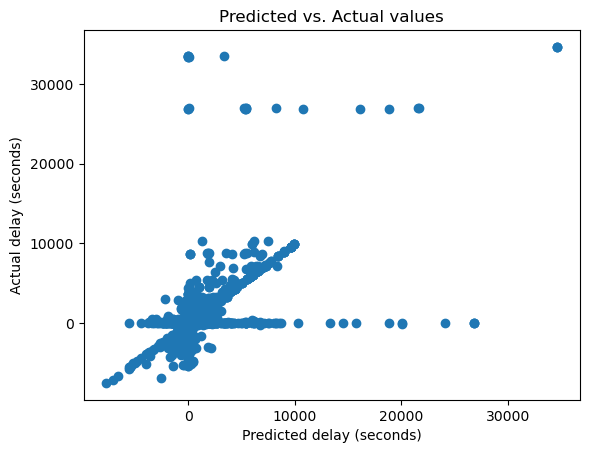

In [9]:
# Plot predicted vs. actual values
plt.scatter(x=y_pred, y=y_val)
plt.title('Predicted vs. Actual values')
plt.xlabel('Predicted delay (seconds)')
plt.ylabel('Actual delay (seconds)')
plt.savefig('../images/actual_vs_predict_base.png', bbox_inches='tight')
plt.show()

There is clustering near small values, which is good, but for large delays, the model tends to underestimate. Some very high delays are flattened horizontally, as if the model "gives up" on predicting outliers and regresses them back toward the mean.

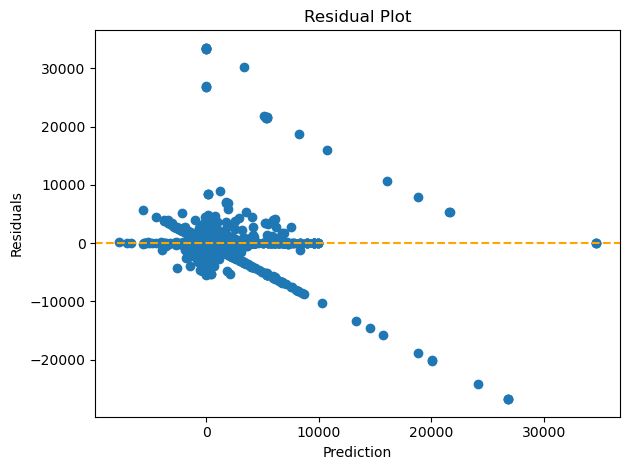

In [10]:
# Plot residuals
residuals = y_val - y_pred
    
plt.scatter(x=y_pred, y=residuals)
plt.title('Residual Plot')
plt.xlabel('Prediction')
plt.ylabel('Residuals')
plt.axhline(0, linestyle="--", color="orange")
plt.tight_layout()
plt.savefig('../images/residual_plot_base.png', bbox_inches='tight')
plt.show()

There are two visible funnel shapes and points clustered around 0. This suggests heteroscedasticity (the model doesn't handle big delays very well) and extreme outliers.

#### K-Fold Cross Validation

In [11]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
scores = cross_val_score(base_model, X_train, y_train, scoring=mse_scorer, cv=5, n_jobs=-1)
rmse_scores = np.sqrt(-scores)
print("Cross-validated RMSE: ", rmse_scores.mean())

Cross-validated RMSE:  334.8261736933474


#### Feature importances

In [12]:
importances = base_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in base_model.estimators_], axis=0)

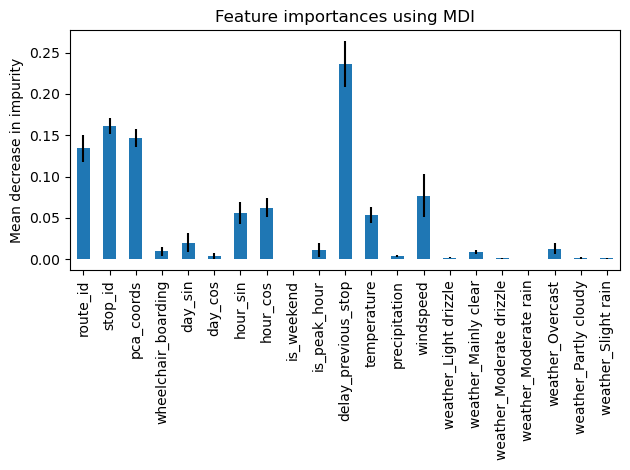

In [ ]:
# Plot the impurity-based importance (MDI)
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()
plt.savefig('../images/mdi_base.png')
plt.show()

The previous stop delay is the most significant feature in the model, which makes sense because delays propagate through the route. The route, stop, position are also relevant because some lines and stops are more likely to have delays. The hour of day being relevant is no surprise. Also, it's interesting to see that the temperature and the windspeed have an impact on the model as well.

### Hyparameter tuning with GridSearchCV

## Model ensembling: Random Forest + Gradient Boosting

## XGBoost

## Final Model

### Evaluation

### Make Prediction

## End